In [32]:
import numpy as np
from qiskit.visualization import array_to_latex
from qiskit import QuantumCircuit, transpile, assemble, Aer
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from numpy.random import randint
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import pandas as pd
import qiskit.quantum_info as qi
import time
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [2]:
class bit_gen:
    
    def __init__(self,n):
        self.n = n
               
    def bitsorbases(self,n):
        bits_or_bases = randint(2, size=n)
        return bits_or_bases


In [3]:
#This function will create a quantum circuit that produces the |00> |01> |10> or |11> configuration
def create_message(n,bits,bases):
    qc_out = []
    if len(bits)==len(bases):
        for i in range(n):
            #create basis vectors
            qc = QuantumCircuit(n,n) #need to update this for noise model
            if bases[i] == 0:
                if bits[i] == 0:
                    pass
                else:
                    qc.x(0)
            else:
                if bits[i] == 0:
                    qc.h(0)
                else:
                    qc.x(0)
                    qc.h(0)
                    
            encode_vec = qi.Statevector.from_instruction(qc)
            qc.barrier()
            qc.draw()
            qc_out.append(qc)
    else:
        print("Bits and basis vectors are unequal")
    return    qc_out

In [47]:
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [54]:
def measure_message(n, bases, qc, nm):
    
    measurements = []
    for i in range(n):
        
        if bases[i] == 0:
            #Measure in z basis
            qc[i].measure(0,0)
        else:
            #Measure in x basis
            qc[i].h(0)
            qc[i].measure(0,0)
        qc[i].draw()
         
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(qc[i], noise_model=nm, shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
        
    return measurements, qc

In [55]:
def public_key(n,a_bits,a_bases,b_bases,e_bases,eve_present,nm):
    
    #process to get public key
    alice_message = create_message(n,a_bits,a_bases)
    
    #Eve present
    if eve_present == 1:
        eve_message = measure_message(n,e_bases,alice_message,nm)[0]
    else:
        eve_message=0
        
    #Bob performs normal measurement
    bobs_message = measure_message(n,b_bases,alice_message,nm)[0]
    #return quantum circuit and see if we can do privacy ampliification with it
    qc = measure_message(n,b_bases,alice_message,nm)[1]

 
    return bobs_message, a_bits, a_bases, b_bases, e_bases, eve_message, qc

In [56]:
def filter_bits(n, bits,bases1,bases2):

    filtered_bits = []
    #filter all the bits for the message and see if they line up
    for i in range(n):
        if bases1[i] == bases2[i]:
            filtered_bits.append(bits[i])
        else:
            pass
        
    return  filtered_bits

In [59]:
def get_key(n,eve_present,nm):
       
    n=n
    eve_present=eve_present
    nm=nm
    
    #generate random bits and bases from class instance
    bits_bases = bit_gen(n)
    abits  = bits_bases.bitsorbases(n)
    abases = bits_bases.bitsorbases(n)
    bbases = bits_bases.bitsorbases(n)
    ebases = bits_bases.bitsorbases(n)

    key = public_key(n=n,a_bits=abits,a_bases=abases,b_bases=bbases,e_bases=ebases,eve_present=eve_present,nm=nm)
    b_mess  = key[0]
    a_bits  = key[1]
    a_bases = key[2]
    b_bases = key[3]
    qc      = key[6]

    alices_bits = filter_bits(n,a_bits,a_bases,b_bases)
    bobs_bits   = filter_bits(n,b_mess,a_bases,b_bases)

    matched_key = []
        
    if eve_present==1:
        e_bases  = key[4]
        e_mess   = key[5]
        eves_key = []

        for i in range(len(alices_bits)):
            if alices_bits[i]==e_mess[i]:
                eves_key.append(e_mess[i])
        
    else:
        pass
   
    
    for i in range(len(alices_bits)):
        if alices_bits[i]==bobs_bits[i]:
            matched_key.append(alices_bits[i])
   
  
    return matched_key, alices_bits, bobs_bits, qc

   alices bits no int bobs bits no int matched key no int  \
0                 [1]              [1]                [1]   
1                 [0]              [0]                [0]   
2                  []               []                 []   
3                 [0]              [1]                [1]   
4                  []               []                 []   
5                 [0]              [0]                [0]   
6              [1, 1]           [0, 0]             [0, 0]   
7                 [1]              [0]                [0]   
8              [0, 0]           [1, 1]             [1, 1]   
9              [0, 1]           [1, 0]             [1, 0]   
10                [1]              [1]                [1]   
11                [1]              [1]                [1]   
12                [1]              [1]                [1]   
13                [0]              [0]                [0]   
14             [0, 1]           [0, 1]             [0, 1]   
15                [1]   

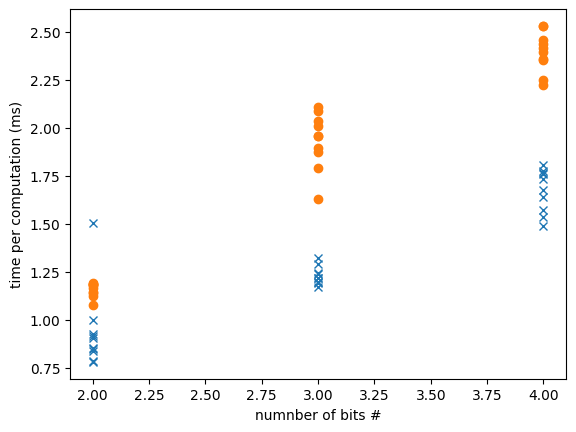

In [70]:
#Inputs used to evaulate performance
n = np.linspace(2,4,3).astype(int)
eve_being_present = np.linspace(0,1,2).astype(int)
#noise model incoropated, use to set how much noise we want, then add as sweep parameter
sweep = np.linspace(0,1,10)

mkey  = []
akey  = []
bkey  = []
times = []
qc    = []
nout  = []
noisy = []

d_no_int=pd.DataFrame()
d_int=pd.DataFrame()

for y in eve_being_present:
    for i in n:
        for j in sweep:
            start = time.time()
            out = get_key(i, y, get_noise(j))
            mkey.append(out[0])
            akey.append(out[1])
            bkey.append(out[2])
            nout.append(i)
            qc.append(out[3])
            noisy.append(j)
            end = time.time()
            times.append((end-start)*100)

#The more bits that match up the more errors we could get, and the greater the comp time
akey_no_int = akey[:len(akey)//2]
bkey_no_int = bkey[:len(bkey)//2]
mkey_no_int = bkey[:len(mkey)//2]
nout_no_int = nout[:len(nout)//2]
times_no_int = times[:len(times)//2]


akey_int = akey[len(akey)//2:]
bkey_int = bkey[len(bkey)//2:]
mkey_int = bkey[len(mkey)//2:]
nout_int = nout[len(nout)//2:]
times_int = times[len(times)//2:]

        
d_no_int['alices bits no int']       = akey_no_int
d_no_int['bobs bits no int']         = bkey_no_int
d_no_int['matched key no int']       = mkey_no_int
d_no_int['time to calculate no int'] = times_no_int
d_no_int['number of bits no int']   = nout_no_int
d_int['alices bits int']          = akey_int
d_int['bobs bits int']            = bkey_int
d_int['matched key int']          = mkey_int
d_int['time to calculate int']    = times_int
d_int['number of biits int']      = nout_int

#d['quantum circuit']   = qc
#d['percent of matched bits'] = percent_of_matched_bits


print(d_no_int)
print(d_int)

plt.plot(nout_no_int,times_no_int, 'x')
plt.plot(nout_int,times_int, 'o')
plt.xlabel('numnber of bits #')
plt.ylabel('time per computation (ms)')
plt.show()



#QBER false counts/correct counts